In [28]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from transformers import AutoConfig, AutoModelForCausalLM, PreTrainedModel
from safetensors.torch import load_model, save_model, safe_open, _remove_duplicate_names
from weak_to_strong.model import TransformerWithHead
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from datasets import load_dataset
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.utils import gen_batches
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
print(f"{torch.cuda.get_device_name()}")
print(f'available devices: {torch.cuda.device_count()}')
print(f'current device: {torch.cuda.current_device()}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NVIDIA A40
available devices: 1
current device: 0


# Header

## Hook

In [3]:
def get_activation(name, activations):
    """ Helper function to capture the activation at each layer. """
    def hook(model, input, output):
        # We expect 'output' to be a tuple where the first element is the last hidden state
        activations[name] = output[0].detach().to(device)
    return hook

def extract_hidden_states(model, datapoint):
    """ Extract hidden states for all layers of a given model for a specific datapoint. """
    activations = {}
    hooks = []

    # Registering hooks for each layer of the transformer
    for name, module in model.transformer.named_modules():
        if isinstance(module, torch.nn.modules.Module):  # You may want to filter only certain types of layers
            hook = module.register_forward_hook(get_activation(name, activations))
            hooks.append(hook)
    
    datapoint = datapoint.to(device)
    
    # Run the datapoint through the model
    model.eval()
    with torch.no_grad():
        _ = model(datapoint)

    # Remove hooks after use
    for hook in hooks:
        hook.remove()

    return activations

In [4]:
def print_layer_names(activations):
    stor = []
    for key, val in activations.items(): 
        stor.append(key)
        print(key)
    return key

## Run on Model

In [17]:
def load_model_modified(model: torch.nn.Module, filename, strict: bool = True, device = "cpu"):
    """
    modified the load_model from safetensors.torch to resolve device error (device = 0)
    """
    tensors = {}
    with safe_open(filename, framework="pt", device=0) as f:
        for k in f.keys():
            tensors[k] = f.get_tensor(k)
        
    state_dict = tensors
    
    model_state_dict = model.state_dict()
    to_removes = _remove_duplicate_names(model_state_dict, preferred_names=state_dict.keys())
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    missing = set(missing)
    for to_remove_group in to_removes.values():
        for to_remove in to_remove_group:
            if to_remove not in missing:
                unexpected.append(to_remove)
            else:
                missing.remove(to_remove)
    if strict and (missing or unexpected):
        missing_keys = ", ".join([f'"{k}"' for k in sorted(missing)])
        unexpected_keys = ", ".join([f'"{k}"' for k in sorted(unexpected)])
        error = f"Error(s) in loading state_dict for {model.__class__.__name__}:"
        if missing:
            error += f"\n    Missing key(s) in state_dict: {missing_keys}"
        if unexpected:
            error += f"\n    Unexpected key(s) in state_dict: {unexpected_keys}"
        raise RuntimeError(error)
    return missing, unexpected

In [7]:
def compare_models(model_name, finetuned_model_path, datapoint): 
    """ Extract and compare hidden states from two models for a given datapoint. """
        # Load both models
    pre_model = TransformerWithHead.from_pretrained(model_name).to(device)
    post_model = TransformerWithHead.from_pretrained(model_name)
    
    load_model_modified(post_model, finetuned_model_path, device)

    post_model = post_model.to(device)
    
    # datapoint = datapoint.to(model1.device)  # Ensure datapoint is on the same device as model
    activations_model1 = extract_hidden_states(pre_model, datapoint)
    activations_model2 = extract_hidden_states(post_model, datapoint)
    
    return activations_model1, activations_model2

In [8]:
def convert_input(text, model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name) 

    # Tokenize the text and convert to input IDs
    tokens = tokenizer.tokenize(text)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    datapoint = torch.tensor([input_ids])
    
    return datapoint

In [50]:
def extract_act_pipeline(model_name, train_data, finetuned_model_path, layer_name = "h.11"): 
    pre_ft_activations = []
    post_ft_activations = []
    print("Converting input to activations.")
    for datapoint in tqdm(train_data):
        activations_model1, activations_model2 = compare_models(model_name, finetuned_model_path, datapoint)
        
        pre_ft_activations.append(activations_model1)
        post_ft_activations.append(activations_model2)
        
    print("Activation Loaded.")
    return pre_ft_activations, post_ft_activations


## Plot

### Plot 1: PCA of one layer

In [25]:
def plot_activation_changes(activations_pre, activations_post, layer_name =11, method='PCA', components=2):
    """
    Visualize changes in activations using PCA or t-SNE.

    Parameters:
    activations_pre (dict): Activations from the model before finetuning.
    activations_post (dict): Activations from the model after finetuning.
    layer_name (str): The layer whose activations are to be visualized.
    method (str): 'PCA' or 't-SNE', the method to use for dimensionality reduction.
    components (int): Number of components for the dimensionality reduction.
    """
    # Extract activations for a specific layer
    data_pre = activations_pre[layer_name].cpu().numpy()
    data_post = activations_post[layer_name].cpu().numpy()
    
    # Check if data is three-dimensional and apply mean pooling if so
    if data_pre.ndim == 3:
        # Mean across the sequence length dimension
        data_pre = data_pre.mean(axis=0)
    if data_post.ndim == 3:
        # Mean across the sequence length dimension
        data_post = data_post.mean(axis=0)
    
    # Concatenate data from both states for unified transformation in PCA/t-SNE
    data_combined = np.concatenate([data_pre, data_post], axis=0)
    
    if method == 'PCA':
        reducer = PCA(n_components=components)
    elif method == 't-SNE':
        reducer = TSNE(n_components=components, learning_rate='auto', init='random')
    else:
        raise ValueError("Unsupported dimensionality reduction method")
    
    # Fit and transform the data
    reduced_data = reducer.fit_transform(data_combined)
    
    # Split the transformed data
    reduced_data_pre = reduced_data[:data_pre.shape[0]]
    reduced_data_post = reduced_data[data_pre.shape[0]:]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_data_pre[:, 0], reduced_data_pre[:, 1], c='blue', alpha=0.5, label='Pre-Finetuning')
    plt.scatter(reduced_data_post[:, 0], reduced_data_post[:, 1], c='red', alpha=0.5, label='Post-Finetuning')
    plt.title(f'Layer: {layer_name} - {method} Visualization')
    plt.xlabel(f'{method} Component 1')
    plt.ylabel(f'{method} Component 2')
    plt.legend()
    plt.show()

### Plot 2: PCA for 1 datapoint through all layers

In [29]:
def plot_activation_changes_all_layers(pre_ft_activations, post_ft_activations, datapoint_index, components=2):
    x_coords = []
    y_coords = []
    labels = []
    for layername in pre_ft_activations[datapoint_index]:
        data_pre = pre_ft_activations[datapoint_index][layername].cpu().numpy().reshape(1, -1)
        data_post = post_ft_activations[datapoint_index][layername].cpu().numpy().reshape(1, -1)
    
        data_combined = np.concatenate([data_pre, data_post], axis=0)
    
        reduced_data = PCA(n_components=components).fit_transform(data_combined)
    
        # Split the transformed data
        reduced_data_pre = reduced_data[0, :]
        reduced_data_post = reduced_data[1, :]
    
        #print(f"{layername}: {reduced_data_pre}, {reduced_data_post}")
    
        # Calculate midpoint for better visualization
        midpoint_x = (reduced_data_pre[0] + reduced_data_post[0]) / 2
        midpoint_y = (reduced_data_pre[1] + reduced_data_post[1]) / 2
    
        x_coords.append(midpoint_x)
        y_coords.append(midpoint_y)
        labels.append(layername)
    
    
    # Create plot
    plt.figure(figsize=(14, 10))
    plt.scatter(x_coords, y_coords, color='red')
    
    # Annotate each point in the scatter plot
    for i, label in enumerate(labels):
        plt.annotate(label, (x_coords[i], y_coords[i]))
    
    plt.title('PCA-transformed Activation Differences')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.show()

### Plot 3: TSNE for 1 datapoint through selected layers

In [133]:
def plot_layer_activations_tsne(activations_pre, activations_post, layer_names, data_index=0, perplexity=5, learning_rate=200):
    """
    Visualize changes in activations across all layers for a specific data point using t-SNE.

    Parameters:
    activations_pre (dict): Activations from the model before finetuning.
    activations_post (dict): Activations from the model after finetuning.
    layer_names (list): List of layer names to be visualized.
    data_index (int): Index of the data point to visualize.
    perplexity (int): Perplexity parameter for t-SNE.
    learning_rate (int): Learning rate parameter for t-SNE.
    """

    # Collect all layers' activations for a specific data point
    all_activations_pre = []
    all_activations_post = []
    for layer_name in layer_names:
        all_activations_pre.append(activations_pre[data_index][layer_name].cpu().numpy().reshape(-1))
        all_activations_post.append(activations_post[data_index][layer_name].cpu().numpy().reshape(-1))

    # Combine data for t-SNE
    data_combined = np.vstack(all_activations_pre + all_activations_post)

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, init='random', random_state=42)
    tsne_results = tsne.fit_transform(data_combined)

    # Split the transformed data into pre- and post-finetuning groups
    tsne_pre = tsne_results[:len(layer_names)]
    tsne_post = tsne_results[len(layer_names):]

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_pre[:, 0], tsne_pre[:, 1], c='blue', label='Pre-Finetuning', alpha=0.5)
    plt.scatter(tsne_post[:, 0], tsne_post[:, 1], c='red', label='Post-Finetuning', alpha=0.5)

    for i, layer_name in enumerate(layer_names):
        plt.text(tsne_pre[i, 0], tsne_pre[i, 1], f'{layer_name} (Pre)', fontsize=8, color='blue')
        plt.text(tsne_post[i, 0], tsne_post[i, 1], f'{layer_name} (Post)', fontsize=8, color='red')

    plt.legend()
    plt.title('t-SNE Visualization of Layer Activations')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

## Miminize Loss

In [ ]:
#### SCIPY MINIMIZE

def loss_per_sample(params, lambda_x, lambda_x_tilde, dim):
    A_len = dim**2
    A = params[:A_len].reshape(dim, dim)
    delta = params[A_len:].reshape(dim, 1)
    transformed = lambda_x @ A + delta.T  # Note the transpose to match dimensions
    loss = np.linalg.norm(transformed - lambda_x_tilde, 'fro')**2
    return loss

def loss_function(params, batch_pre_ft, batch_post_ft, dim):
    losses = [loss_per_sample(params, pre_ft, post_ft, dim) for pre_ft, post_ft in zip(batch_pre_ft, batch_post_ft)]
    return np.sum(losses) / len(batch_pre_ft)


def optimize_Adelta(pre_ft_activations, post_ft_activations, batch_size, tol=1e-5, max_iter=10):
    # activation list shape: n_sample * (token_num * feature)
    # A shape: feature * feature
    # delta shape: 1 * feature 
    # batch list shape: batch_size * (token_num * feature)
    dim = pre_ft_activations[0].shape[1]
    print(dim)
    A_len = dim**2
    print(A_len)

    # Initialize A and delta
    A_init = np.eye(dim).flatten()
    delta_init = np.zeros((dim, 1)).flatten()
    initial_params = np.concatenate([A_init, delta_init])

    n_samples = len(pre_ft_activations)
    previous_loss = np.inf
    converged = False

    # Function to perform optimization on a batch
    def optimize_batch(start, end, params):
        batch_pre_ft = pre_ft_activations[start:end]
        batch_post_ft = post_ft_activations[start:end]

        result = minimize(
            fun=loss_function,
            x0=params,
            args=(batch_pre_ft, batch_post_ft, dim),
            method= 'L-BFGS-B'
        )
        return result

    # Iterate over mini-batches and optimize
    for iteration in range(max_iter):
        for batch in gen_batches(n_samples, batch_size):
            result = optimize_batch(batch.start, batch.stop, initial_params)

            if result.success:
                initial_params = result.x
                current_loss = result.fun
                loss_change = previous_loss - current_loss
                previous_loss = current_loss

                print(f"Iteration {iteration}, Batch {batch.start}-{batch.stop}, "
                      f"Current Loss: {current_loss:.6f}, Loss Change: {loss_change:.6f}")

                if np.abs(loss_change) < tol:
                    converged = True
                    break
            else:
                print(f"Optimization failed at Iteration {iteration}, Batch {batch.start}-{batch.stop}.")
                break

        if converged:
            print("Convergence criterion met.")
            break
    else:
        print("Reached maximum iterations without convergence.")

    # After going through all batches, reshape the final parameters back into A and delta
    A_optimized = initial_params[:A_len].reshape(dim, dim)
    delta_optimized = initial_params[A_len:].reshape(dim, 1)
    
    print("Optimization finished.")
    return A_optimized, delta_optimized

def avg_samples(act_list): 
    # Compute the mean along the axis 0 (num_tokens dimension)
    res = []
    for act in act_list: 
        mean_values = torch.mean(act, dim=0)

        result = mean_values.unsqueeze(0)
        res.append(result)
    return np.array(res)

# Data Prep

In [10]:
ds_ap = load_dataset("amazon_polarity")

In [11]:
# convert to tensor
datapoints_ap=[]
for i in tqdm(range(100)): 
    entry = ds_ap["train"][i]
    datapoints_ap.append(convert_input(entry['title'] + " " + entry['content'], "gpt2"))

100%|█████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.90it/s]


In [12]:
model_path = "/net/scratch/weak_to_strong/weak-to-strong/results/default/bs=32-dn=anth_hh-e=2-ee=1000000-lp=0-l=xent-l=5e-05-ls=cosi_anne-mc=1024-ms=gpt2-nd=20000-ntd=10000-o=adam-s=0-twd=0/model.safetensors"
#fine-tuned model path

In [16]:
model = TransformerWithHead.from_pretrained('gpt2')
load_model_modified(model, model_path, device)

successful


(set(), [])

In [27]:
for nae, param in model.named_parameters():
    print(name)

lm.transformer.wte.weight
lm.transformer.wpe.weight
lm.transformer.h.0.ln_1.weight
lm.transformer.h.0.ln_1.bias
lm.transformer.h.0.attn.c_attn.weight
lm.transformer.h.0.attn.c_attn.bias
lm.transformer.h.0.attn.c_proj.weight
lm.transformer.h.0.attn.c_proj.bias
lm.transformer.h.0.ln_2.weight
lm.transformer.h.0.ln_2.bias
lm.transformer.h.0.mlp.c_fc.weight
lm.transformer.h.0.mlp.c_fc.bias
lm.transformer.h.0.mlp.c_proj.weight
lm.transformer.h.0.mlp.c_proj.bias
lm.transformer.h.1.ln_1.weight
lm.transformer.h.1.ln_1.bias
lm.transformer.h.1.attn.c_attn.weight
lm.transformer.h.1.attn.c_attn.bias
lm.transformer.h.1.attn.c_proj.weight
lm.transformer.h.1.attn.c_proj.bias
lm.transformer.h.1.ln_2.weight
lm.transformer.h.1.ln_2.bias
lm.transformer.h.1.mlp.c_fc.weight
lm.transformer.h.1.mlp.c_fc.bias
lm.transformer.h.1.mlp.c_proj.weight
lm.transformer.h.1.mlp.c_proj.bias
lm.transformer.h.2.ln_1.weight
lm.transformer.h.2.ln_1.bias
lm.transformer.h.2.attn.c_attn.weight
lm.transformer.h.2.attn.c_attn.bia

# Running Code

In [51]:
pre_ft_activations, post_ft_activations = extract_act_pipeline("gpt2", datapoints_ap, model_path) 

Converting input to activations.


100%|█████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]

Activation Loaded.


In [ ]:
pre_ft_activations

plot_activation_changes(pre_ft_activations, post_ft_activations)

In [55]:
pre_ft_activations[1]

{'wte': tensor([[-0.0686, -0.0203,  0.0645,  ...,  0.0639, -0.0100,  0.0031],
         [-0.1508,  0.0555,  0.0261,  ..., -0.1873, -0.1542, -0.0471],
         [-0.1257, -0.0675,  0.0955,  ...,  0.1913,  0.1224,  0.0394],
         ...,
         [ 0.1728, -0.0851,  0.0302,  ..., -0.1335, -0.0340,  0.0110],
         [ 0.1668, -0.3234,  0.1787,  ...,  0.3306, -0.1410,  0.0480],
         [ 0.0466, -0.0113,  0.0283,  ..., -0.0735,  0.0496,  0.0963]],
        device='cuda:0'),
 'wpe': tensor([[-1.8821e-02, -1.9742e-01,  4.0267e-03,  ..., -4.3044e-02,
           2.8267e-02,  5.4490e-02],
         [ 2.3959e-02, -5.3792e-02, -9.4879e-02,  ...,  3.4170e-02,
           1.0172e-02, -1.5573e-04],
         [ 4.2161e-03, -8.4764e-02,  5.4515e-02,  ...,  1.9745e-02,
           1.9325e-02, -2.1424e-02],
         ...,
         [-5.1601e-03, -2.4408e-02, -2.1584e-03,  ..., -3.4939e-04,
          -3.2103e-03, -6.2854e-03],
         [-2.0419e-03, -1.7615e-02, -8.0451e-03,  ...,  4.7559e-03,
          -1.5646

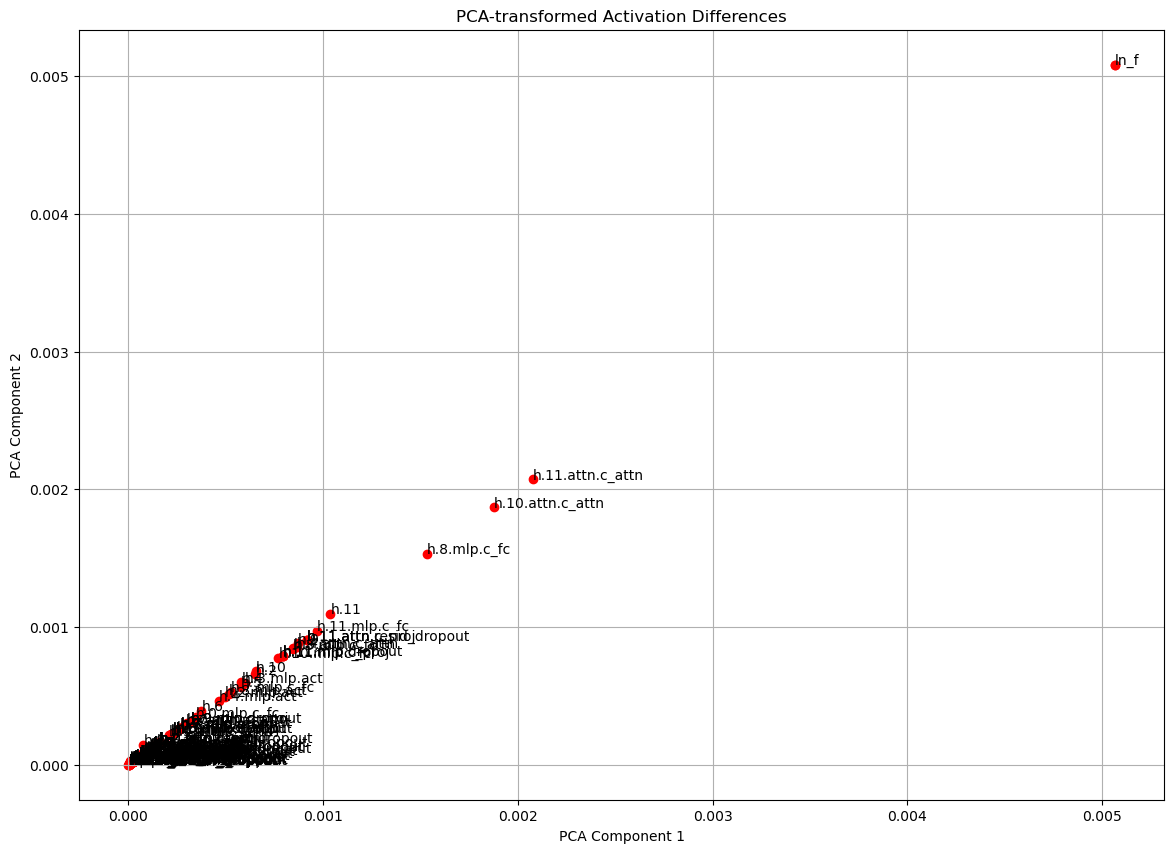

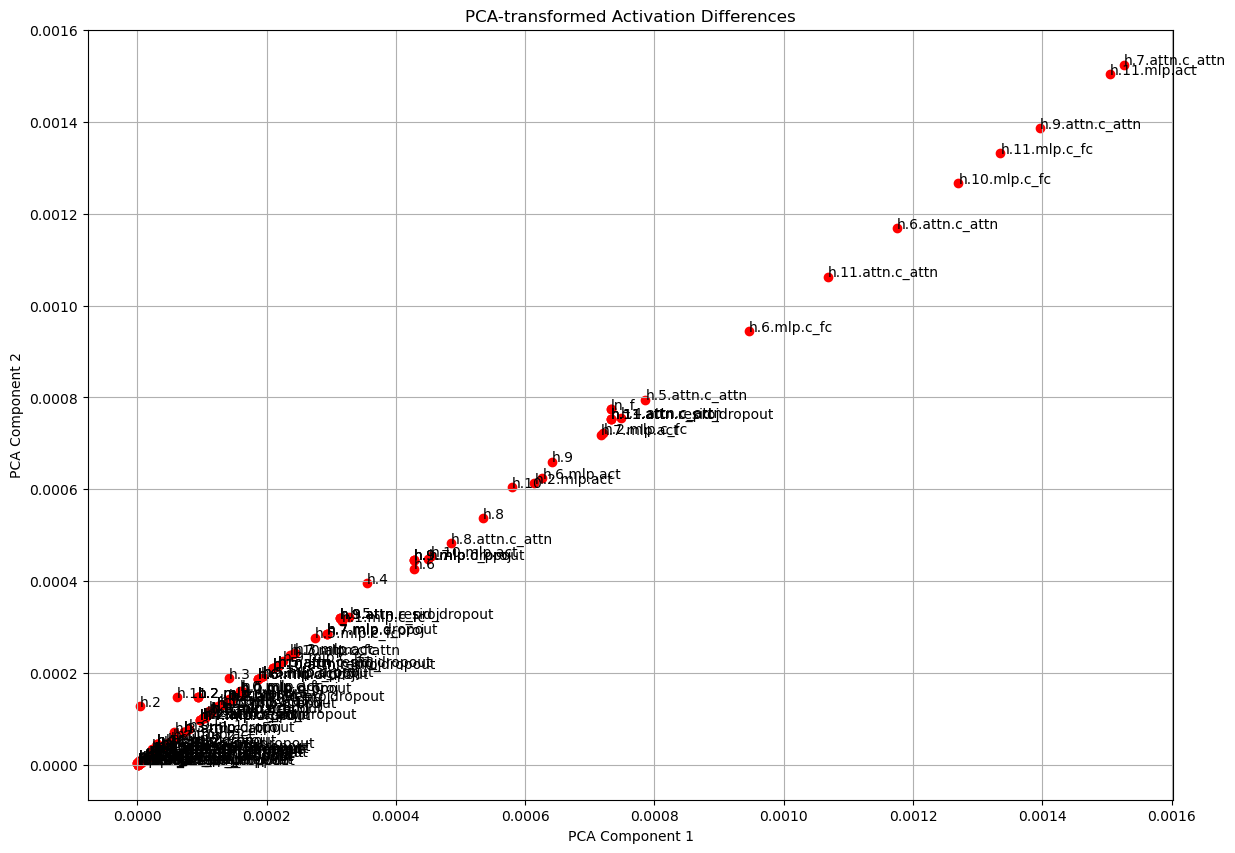

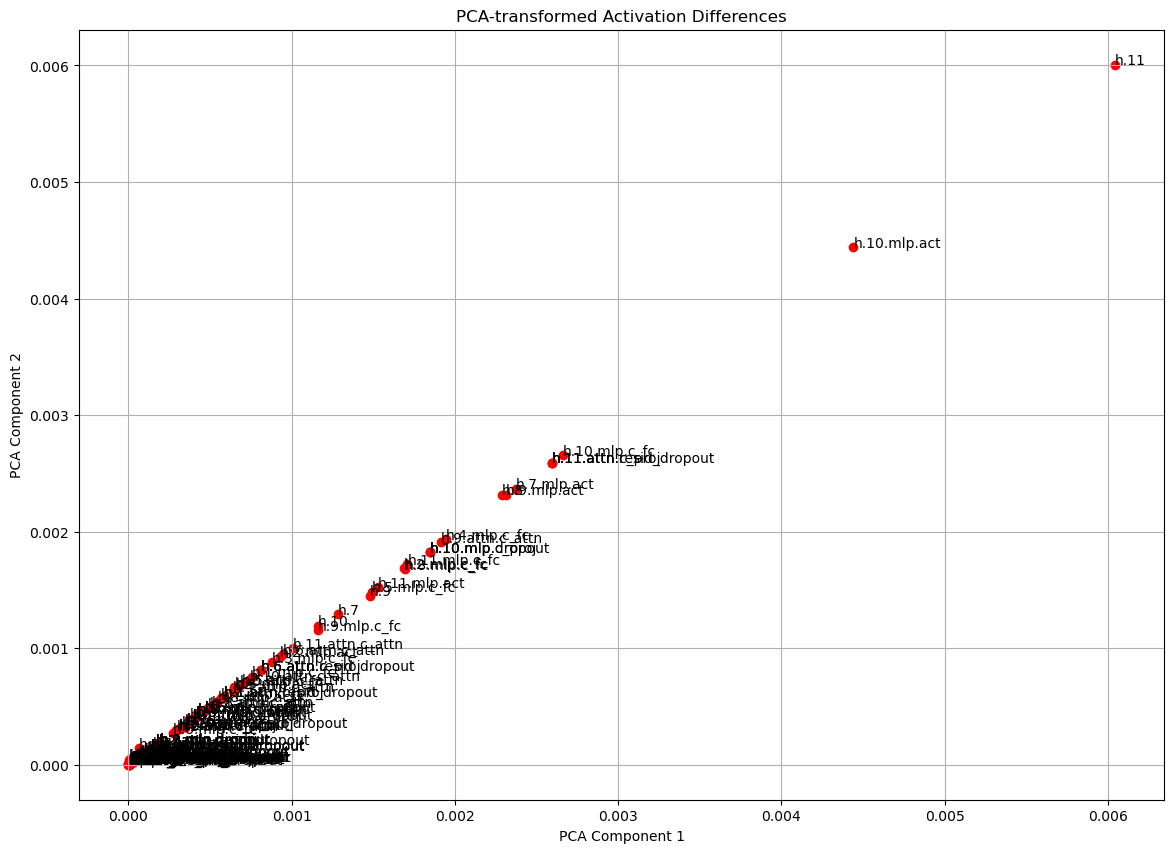

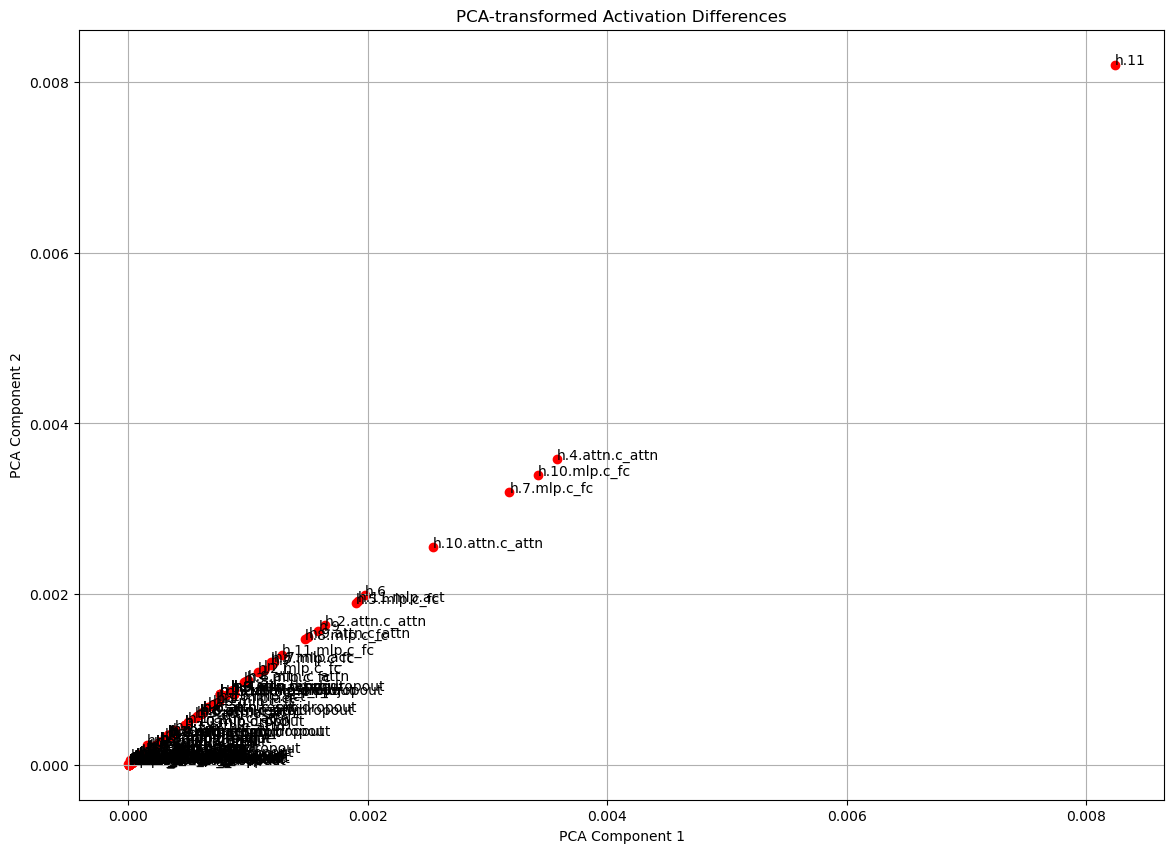

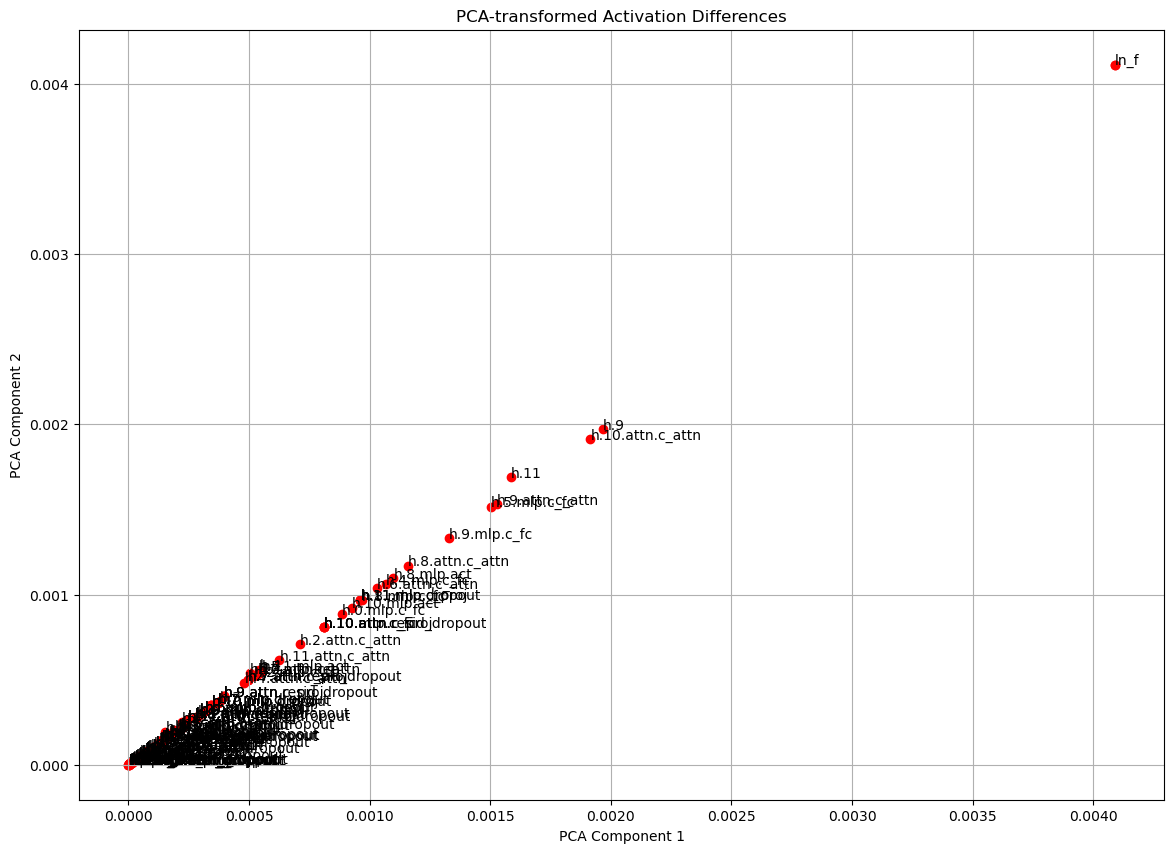

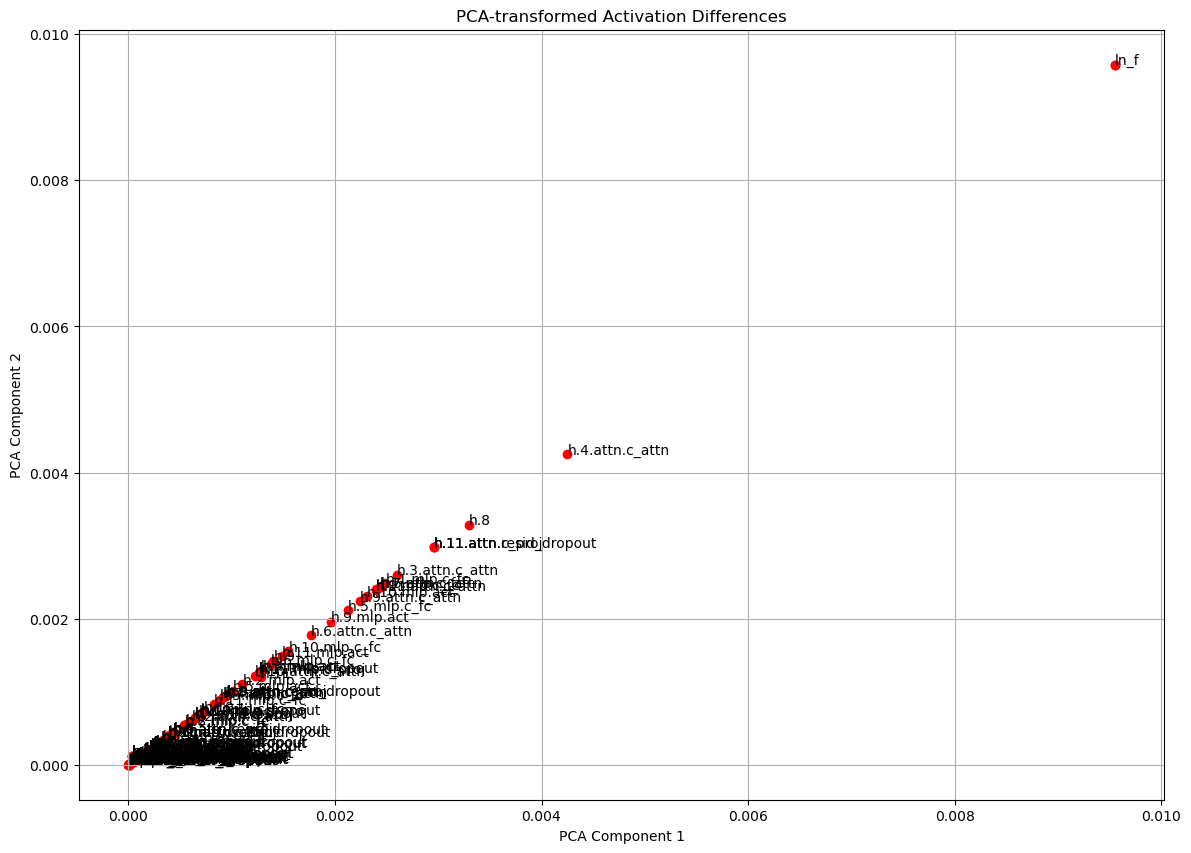

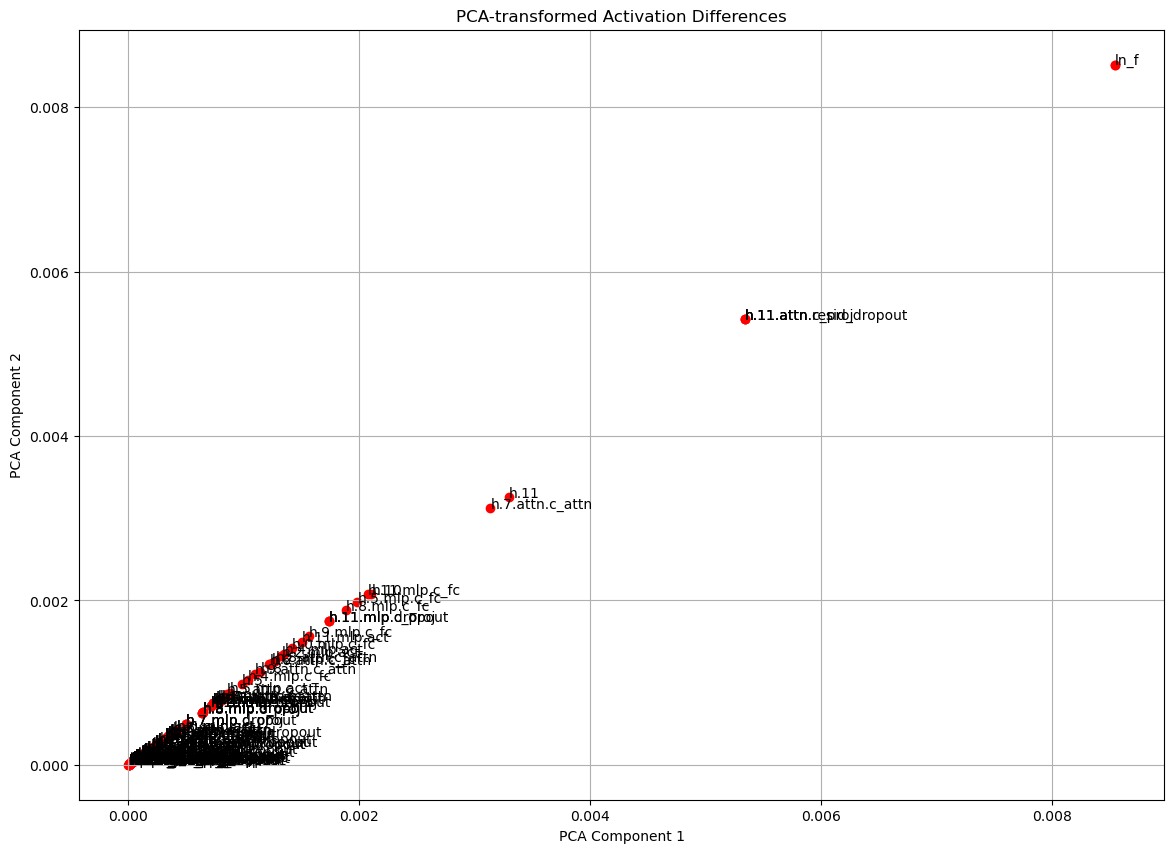

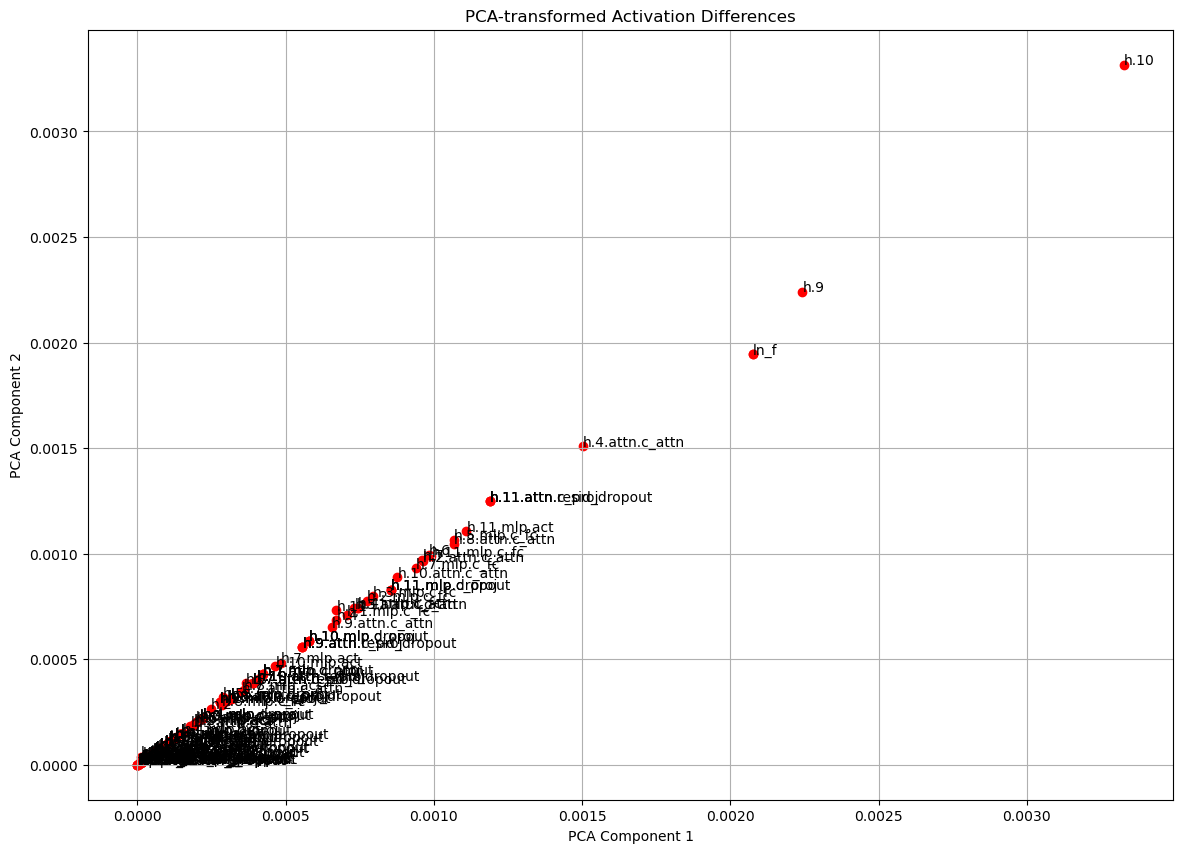

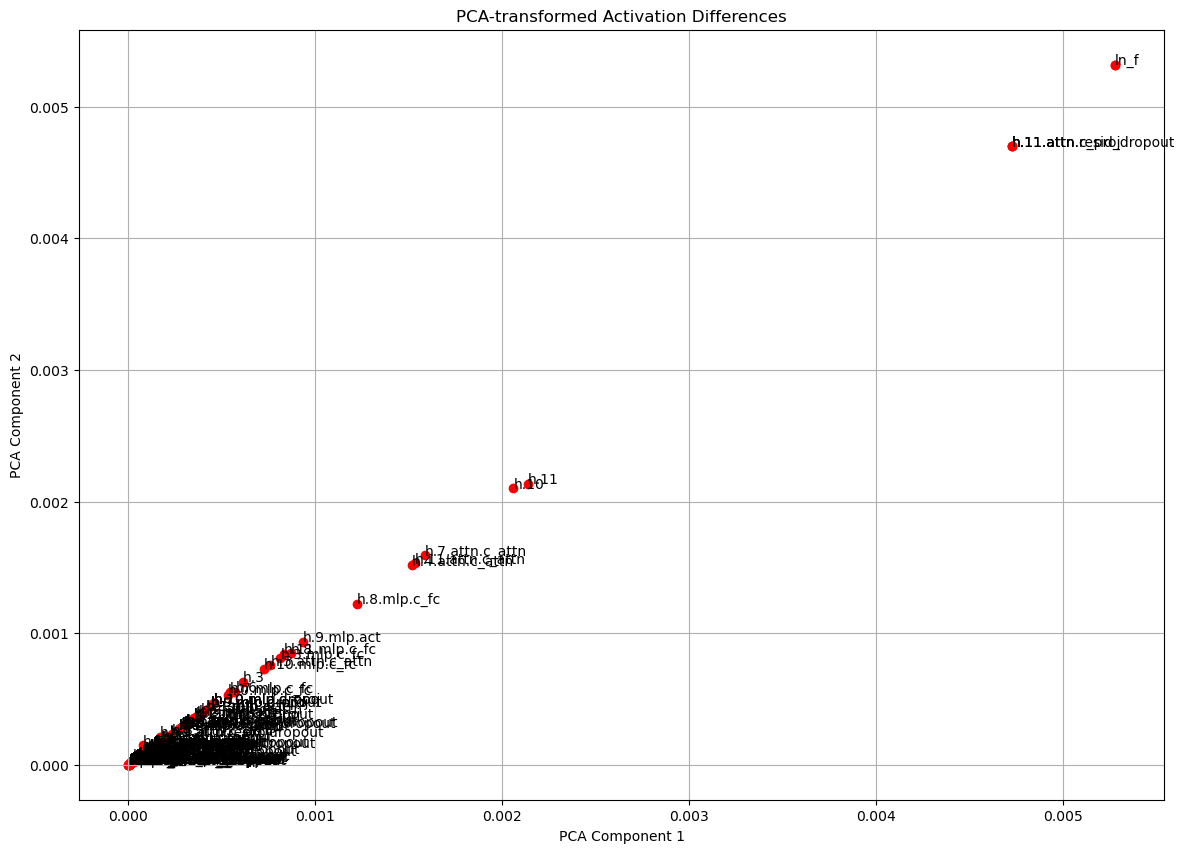

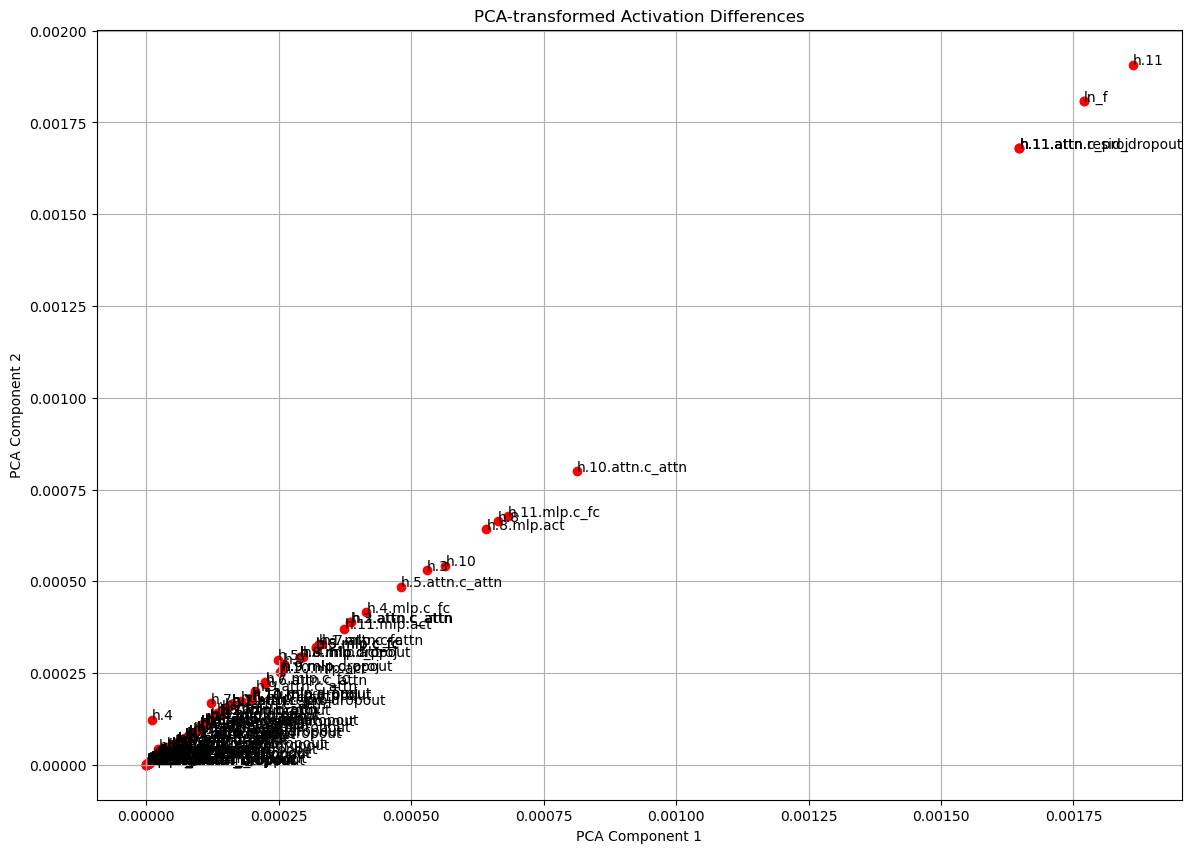

In [88]:
for i in range(10):
    plot_activation_changes_all_layers(pre_ft_activations, post_ft_activations, i)

In [104]:
def plot_activation_changes(activation1, activation2, components=2, title=''):

    # copy tensors from cuda to host memory
    activation1 = activation1.cpu().numpy().reshape(1, -1)
    activation2 = activation2.cpu().numpy().reshape(1, -1)
    
    # Concatenate data from both states for unified transformation in PCA/t-SNE
    data_combined = np.concatenate([activation1, activation2], axis=0)
    
    reduced_data = TSNE(n_components=components, learning_rate='auto', init='random').fit_transform(data_combined)
    
    # Split the transformed data
    reduced_data_pre = reduced_data[:activation1.shape[0]]
    reduced_data_post = reduced_data[activation1.shape[0]:]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_data_pre[:, 0], reduced_data_pre[:, 1], c='blue', alpha=0.2, label='Pre-Finetuning')
    plt.scatter(reduced_data_post[:, 0], reduced_data_post[:, 1], c='red', alpha=0.2, label='Post-Finetuning')
    plt.title(f'{title} - {method} Visualization')
    plt.xlabel(f'{method} Component 1')
    plt.ylabel(f'{method} Component 2')
    plt.legend()
    plt.show()

In [156]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

def plot_layer_wide_changes_tsne(activations_pre, activations_post, layer_name, perplexity=30, learning_rate=200):
    """
    Visualize changes in activations for a particular layer across all data points using t-SNE.

    Parameters:
    activations_pre (dict): Activations from the model before finetuning, structured by data points.
    activations_post (dict): Activations from the model after finetuning, structured by data points.
    layer_name (str): Name of the layer to visualize changes for.
    perplexity (int): Perplexity parameter for t-SNE.
    learning_rate (int): Learning rate parameter for t-SNE.
    """
    # Collect activations for all data points in the specified layer
    data_pre = np.array([activations_pre[i][layer_name].cpu().numpy().flatten().reshape(-1) for i in range(len(activations_pre))])
    data_post = np.array([activations_post[i][layer_name].cpu().numpy().flatten().reshape(-1) for i in range(len(activations_post))])

    print(data_pre)
    # Combine data for t-SNE
    data_combined = np.vstack((data_pre, data_post))

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, init='random', random_state=42)
    tsne_results = tsne.fit_transform(data_combined)

    # Split the transformed data into pre- and post-finetuning groups
    tsne_pre = tsne_results[:len(data_pre)]
    tsne_post = tsne_results[len(data_pre):]

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_pre[:, 0], tsne_pre[:, 1], c='blue', label='Pre-Finetuning', alpha=0.5)
    plt.scatter(tsne_post[:, 0], tsne_post[:, 1], c='red', label='Post-Finetuning', alpha=0.5)
    plt.legend()
    plt.title(f't-SNE Visualization of Layer {layer_name} Activations Across All Data Points')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

# Example usage (ensure activations_pre and activations_post are correctly assigned from your data)
plot_layer_wide_changes_tsne(pre_ft_activations, post_ft_activations, 'h.11', perplexity=30, learning_rate=200)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.

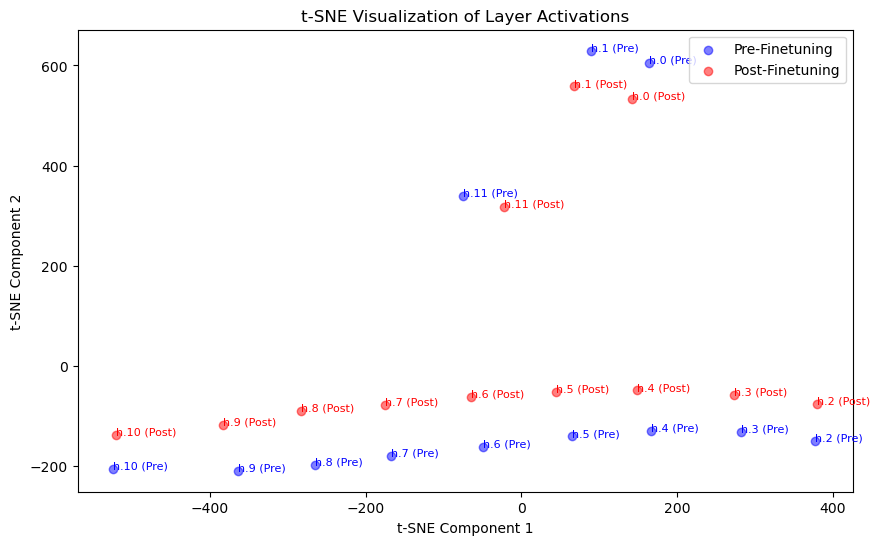

In [132]:
layer_names = ['h.0', 'h.1', 'h.2', 'h.3', 'h.4', 'h.5', 'h.6', 'h.7', 'h.8', 'h.9', 'h.10', 'h.11']
plot_layer_activations_tsne(pre_ft_activations, post_ft_activations, layer_names, 1)

In [148]:
len(pre_ft_activations)

100

In [165]:
for i in range(100):
    print(len(pre_ft_activations[i]['h.11'].cpu().numpy().flatten())) #or add .reshape(-1)

76800
88320
142848
136704
89088
141312
136704
93696
89088
55296
33024
84480
50688
91392
119040
49152
111360
116736
66048
44544
74496
144384
159744
124416
52224
104448
96000
46080
103680
157440
90624
130560
53760
158976
27648
125952
104448
74496
33024
66048
52992
165888
33792
46080
19968
68352
101376
89088
47616
91392
42240
152832
84480
72192
42240
58368
77568
71424
23808
32256
68352
52992
98304
89856
61440
104448
76032
56832
63744
53760
62208
165888
43776
124416
101376
115968
115200
26112
26880
28416
114432
169728
57600
36096
22272
61440
26880
39936
103680
58368
88320
170496
77568
74496
34560
49152
28416
30720
31488
26112
